In [2]:
import numpy as np
np.random.seed(13)

from IPython.display import SVG
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.visualize_util import model_to_dot, plot
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, base_filter
from gensim.models.doc2vec import Word2Vec

### k.mean( )で必要になるので追加
from keras import backend as K

Using Theano backend.


In [3]:
base_filter()
path = 'wakati.tmp'
corpus = open(path).readlines()[0:500]

### new line more than 2 を削除
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

### base_filter に ' を追加
tokenizer = Tokenizer(filters=base_filter()+"'")

### corpus を整形
tokenizer.fit_on_texts(corpus)

### corpus の型を sequence に変更（file 出力できなかった）
corpus = tokenizer.texts_to_sequences(corpus)

### sequence の合計を nb_samples に代入
nb_samples = sum(len(s) for s in corpus)

### 語彙数を数える
V = len(tokenizer.word_index) + 1

### 多分、特徴ベクトルの次元数
dim = 100

### 文脈窓
window_size = 2

In [18]:
### CBOW の定義
def generate_data(corpus, window_size, V):
    maxlen = window_size*2
    
    ### コーパス内の単語数だけ繰り返す
    for words in corpus:
        
        ### リストを生成
        contexts = []
        labels   = []
        L = len(words)

        print ;
        print ;
        print "words: ", words

        
        ### 
        for index, word in enumerate(words):
            s = index-window_size
            e = index+window_size+1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            print "contexts.type: ", type(contexts)
            
            ### contexts は文脈窓範囲内の単語の ID が格納されたリスト
            print "context: ", contexts[index]
            
            labels.append(word)
            
            ### x はシーケンス型、着目する単語の窓範囲内のwordIDを格納したcontexts
            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            
            ### 1 of K 表現に変換
            ### y: シーケンス型、V 次元のベクトルを、contexts だけもつ行列
            ### x を 1 of K 表現にしたもの?
            y = np_utils.to_categorical(labels, V)

            yield (x, y)

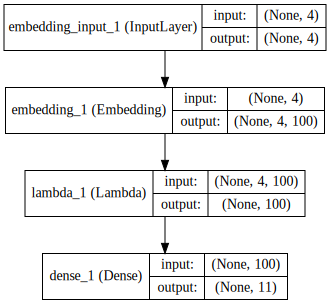

In [5]:
### ネットワーク構造をシーケンシャルに
cbow = Sequential()

### 入力層は Embeddding で固定次元に変換
cbow.add(Embedding(input_dim=V, output_dim=dim, init='glorot_uniform',input_length=window_size*2))

### 入力層の出力を、dim 次元ベクトルの平均値にする
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))

### dim 次元に変換された 4 つの単語を入力とする第二層
cbow.add(Dense(V, init='glorot_uniform', activation='softmax'))

###  スケーラブル・ベクター・グラフィックを生成、表示
SVG(model_to_dot(cbow, show_shapes=True).create(prog='dot', format='svg'))

In [6]:
### 学習過程の確認
cbow.compile(loss='categorical_crossentropy', optimizer="adadelta")

In [19]:
### 学習開始
for ite in range(10):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        print "x: ",
        print type(x),
        print ;
        print x
        print "y: ",
        print type(y),
        print ;
        print y
        loss += cbow.train_on_batch(x, y)
    print(ite, loss)



words:  [8, 1]
contexts.type:  <type 'list'>
context:  [1]
x:  <type 'numpy.ndarray'>
[[0 0 0 1]]
y:  <type 'numpy.ndarray'>
[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]]
contexts.type:  <type 'list'>
context:  [8]
x:  <type 'numpy.ndarray'>
[[0 0 0 1]
 [0 0 0 8]]
y:  <type 'numpy.ndarray'>
[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


words:  [4, 7]
contexts.type:  <type 'list'>
context:  [7]
x:  <type 'numpy.ndarray'>
[[0 0 0 7]]
y:  <type 'numpy.ndarray'>
[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]
contexts.type:  <type 'list'>
context:  [4]
x:  <type 'numpy.ndarray'>
[[0 0 0 7]
 [0 0 0 4]]
y:  <type 'numpy.ndarray'>
[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]


words:  [5, 1, 6, 10, 3, 2, 9]
contexts.type:  <type 'list'>
context:  [1, 6]
x:  <type 'numpy.ndarray'>
[[0 0 1 6]]
y:  <type 'numpy.ndarray'>
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]
contexts.type:  <type 'l

In [49]:
### 書き込み用ファイルを生成
f = open("vectors.txt", "w")

### 語彙数と特徴ベクトルの次元数を書き込む
#f.write( " ".join([str(V-1), str(dim)]) )
#f.write("\n")

In [7]:
vectors = cbow.get_weights()[0]

### 学習で得られた単語の特徴ベクトルを書き込む
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

NameError: name 'f' is not defined

In [8]:
w2v = Word2Vec.load_word2vec_format('./vectors.txt', binary=False)

In [21]:
simResult = w2v.most_similar(positive=[u"疑う"])
for x in simResult:
    print x[0], x[1];

心 0.760085880756
取り直し 0.660530209541
願い 0.650048851967
様 0.64907169342
懐中 0.615660429001
心構え 0.612200021744
真紅 0.60736900568
帰り 0.592604875565
殺し 0.589504122734
牧人 0.588057458401
